```
SOW-MKI95 Computer Graphics & Computer Vision Spring
Variational autoencoders practical
```

```
Group number: 5
Frederike Elsmann (s1060943)
Steffen Ricklin (s1009136)
Ron Hommelsheim (s1000522)
...
```

In [ ]:
from mxnet import autograd, nd, gluon
from mxnet.gluon import nn

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np

import tqdm.notebook as tqdm
import time

%matplotlib inline

### Task 1 (10 points):

* Implement the decoder class for a variational autoencoder.

---o---

Recall that the decoder transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents. Note that it should output the Gaussian parameters (mean and variance per pixel) of images rather than images themselves.

---o---

In [ ]:
class Decoder(nn.HybridSequential):
    def __init__(self, activation='relu', hiddens=400, observables=784, layers=1, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        for _ in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(observables * 2, activation='sigmoid'))

### Task 2 (10 points):

* Implement the encoder class for a variational autoencoder.

---o---

Recall that the encoder transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables. Note that it should output the Gaussian parameters (mean and variance per feature) of features rather than features themselves.

---o---

In [ ]:
class Encoder(nn.HybridSequential):
    def __init__(self, activation='relu', hiddens=400, latents=2, layers=1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        for _ in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(latents * 2))

### Task:

* Implement the loss function class for a variational autoecoder.

---o---

The loss function takes the following arguments as input:

* x        : input images (mini batch)
* x_mean   : mean of the decoded images (output of the decoder)
* x_log_var: log variance of the decoded images (output of the decoder)
* z_mean   : mean of the encoded features (output of the encoder)
* z_log_var: log variance of the encoded features (output of the encoder)

It gives the following evidence lower bound (ELBO) as output:

* $L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

where

* The first term is the KL divergence between the approximate Gaussian posterior (q) and the standard Gaussian prior (p), which can be interpreted as a form of regularization.
* The second term is the Gaussian negative log likelihood, which is the term that fits the data and is very similar to the usual loss functions that are used in deep learning.

---o---

In [ ]:
class Lossfun:
    def __init__(self, w = 1.0):
        self.w = w
        self.soft_zero = 1e-10

    def __call__(self, x, x_mean, x_log_var, z_mean, z_log_var):
        
        # Reconstruction loss
        logloss = nd.sum(x * nd.log(x_mean + self.soft_zero) + (1 - x) * nd.log(1 - x_mean + self.soft_zero), axis=1)
        
        # Variational loss
        KL = 0.5 * nd.sum(1 + z_log_var - z_mean**2 - nd.exp(z_log_var), axis=1)

        # ELBO
        elbo = self.w * KL + logloss
        
        return -elbo

### Task (5 points):

* Implement the variational autoencoder.

In [ ]:
class VariationalAutoencoder(gluon.HybridBlock):
    def __init__(self,  activation='relu', hiddens=400, latents=2, observables=784, layers=1, batch_size=100, **kwargs):
        super(VariationalAutoencoder, self).__init__()
        self.latents = latents
        self.batch_size = batch_size
        with self.name_scope():
            self.encoder = Encoder(activation, hiddens, latents, layers, **kwargs)
            self.decoder = Decoder(activation, hiddens, observables, layers, **kwargs)

    def hybrid_forward(self, F, x):
        h_encoder = self.encoder(x)
        z_mean, z_log_var = F.split(h_encoder, axis=1, num_outputs=2)
        eps = F.random.normal(0, 1, shape=(self.batch_size, self.latents))
        z = z_mean + F.exp(0.5 * z_log_var) * eps
        h_decoder = self.decoder(z)
        x_mean, x_log_var = F.split(h_decoder, axis=1, num_outputs=2)
        return x_mean, x_log_var, z_mean, z_log_var

### Task (25 points):

* Train the variational autoencoder on the Mnist dataset. You can refer to the previous assignment to implement your training loop.

In [ ]:
# Data
mnist = mx.test_utils.get_mnist()
train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

batch_size = 100
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)

In [ ]:
# Initialize network 
layers = 3
vae = VariationalAutoencoder(layers=layers)
gpus = mx.test_utils.list_gpus()
ctx = mx.cpu()
vae.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
vae.hybridize()
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .001})
lossfun = Lossfun(w=1)

epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, Training loss 183.55, Validation loss 170.28
Epoch 5, Training loss 147.15, Validation loss 151.29
Epoch 10, Training loss 144.00, Validation loss 145.78
Epoch 15, Training loss 140.54, Validation loss 142.15
Epoch 20, Training loss 139.16, Validation loss 140.13
Epoch 25, Training loss 139.27, Validation loss 142.24
Epoch 30, Training loss 139.33, Validation loss 142.71
Epoch 35, Training loss 139.73, Validation loss 141.30
Epoch 40, Training loss 158.58, Validation loss 141.22
Epoch 45, Training loss 139.00, Validation loss 142.26
Time elapsed: 1968.08s


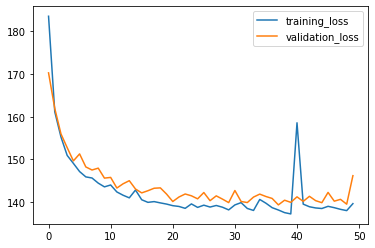

In [ ]:
epochs = 50
print_period = epochs // 10
start = time.time()
training_loss = []
validation_loss = []

for epoch in tqdm.tqdm(range(epochs), desc='epochs'):
    
    epoch_loss = epoch_val_loss = 0
    train_iter.reset(); test_iter.reset()

    # Train
    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        x = batch.data[0].as_in_context(ctx)
        
        with autograd.record():
            x_mean, x_log_var, z_mean, z_log_var = vae(x)
            loss = lossfun(x, x_mean, x_log_var, z_mean, z_log_var)
        loss.backward()
        trainer.step(x.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    # Validation
    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        x = batch.data[0].as_in_context(ctx)
        x_mean, x_log_var, z_mean, z_log_var = vae(x)
        loss = lossfun(x, x_mean, x_log_var, z_mean, z_log_var)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if epoch % max(print_period,1) == 0:
        print(f'Epoch {epoch}, Training loss {epoch_loss:.2f}, Validation loss {epoch_val_loss:.2f}')

end = time.time()
print(f'Time elapsed: {end - start:.2f}s')

plt.plot(training_loss, label='training_loss')
plt.plot(validation_loss, label='validation_loss')
plt.legend()
plt.show()

In [ ]:
# Saving the network
vae.export("vae", epoch=epochs)

# Loading if needed
# vae1 = gluon.nn.SymbolBlock.imports("vae-symbol.json", ['data'], "vae-0050.params", ctx=ctx)

### Task (50 points):
* Evaluate the reconstruction quality of the variational autoencoder: Draw some Mnist like images, encode them, decode them, visualize them and briefly explain the results.
 * Repeat the task with drawings of something else (e.g., a face).
* Evaluate the sampling quality of the variational autoencoder: Sample some random features from the prior, decode them, visualize them and briefly explain the results.
 * Repeat the task with features on a regular grid.
* Evaluate the latent quality of the variational autoencoder: Scatter plot features of images, color code their labels.

### Custom images

In the plot below, the top row are the custom hand drawn images. The bottom row shows the reconstruction. We found by trial and error that a deeper VAE permits a better reconstruction quality. Here, we used 3 layers for the encoder and decoder, respectively. Some digits appear to have been reconstructed successfully - the 0, 2, and 5 - but the others failed. We suspect this has to do both with the quality of the input (no padding, or any other pre-processing as a matter of fact other than normalizing by 255) as well as the VAE itself. A convolutional VAE, e.g., might present better results. The other three images, of a smiley, flower, and wine glass were all not reconstructed successfully. The network is tuned to the digits and is not able to generalize to other images. Again, the (lack of) pre-processing of the data might have an influence but also the latent space is not rich enough for the network to sample from.

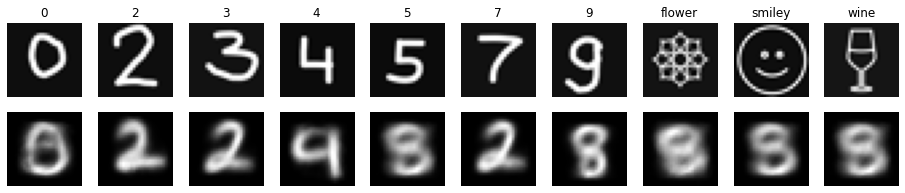

In [ ]:
import glob
from PIL import Image
import cv2 
from scipy.special import ndtri
from scipy.stats import norm

# loading images and labels
images = [cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in glob.glob('img/*.png')]
labels = np.array([filename.split('.')[0].split('/')[1] for filename in glob.glob('img/*.png')])

# sorting
idx = np.argsort(labels)
labels = labels[idx]

# transforming images
images = np.array([np.array(Image.fromarray(img).resize((28, 28))).flatten()/255 for img in images])[idx]

# this is just to comply with batch size 100
images = np.repeat(images, 10, axis=0)
batch_size = images.shape[0]

# data
custom_iter = mx.io.NDArrayIter(data={'data': images}, label={'label': idx}, batch_size=batch_size)
custom_batch = custom_iter.next()
data = custom_batch.data[0].as_in_context(ctx)

# pushing data through the network
out = vae(data)[0]

# Plot
fig, ax = plt.subplots(2, 10, figsize=(16, 3))
for i in range(10):
    ax[0, i].imshow(data[i*10].asnumpy().reshape(28,28), cmap='gray')
    ax[1, i].imshow(out[i*10].asnumpy().reshape(28,28), cmap='gray')
    ax[0, i].set_title(labels[i])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.show()

### MNIST examples

Below we sampled some examples from the original dataset. It seems the network is able to reconstruct the input fairly well, albeit it is not perfect as can be seen in the reconstruction of the 4 which looks like a 9.

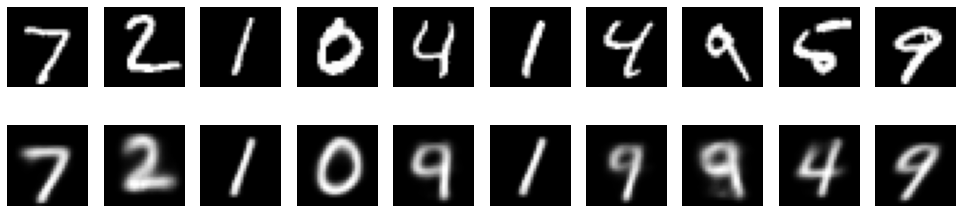

The top row are the original images. The bottom row are the reconstructions.


In [ ]:
# Sampling from test data and reconstruction

# Example batch
test_iter.reset()
test_batch = test_iter.next()
test_batch = test_batch.data[0].as_in_context(ctx)
original = test_batch
result = vae(test_batch)[0]

# Plot
fig, ax = plt.subplots(2,10, figsize=(17,4))
for j in range(10):
    ax[0,j].imshow(original[j].asnumpy().reshape((28,28)), cmap='gray')
    ax[1,j].imshow(result[j].asnumpy().reshape((28,28)), cmap='gray')
    ax[0,j].axis('off')
    ax[1,j].axis('off')
plt.show()
print(f'The top row are the original images. The bottom row are the reconstructions.')

### Sampling latent features from prior

Here, we just sampled a random latent feature of the prior, mean 0.5 and variance 1. We can see that this resembles a 2. When plotting the whole grid, while making sure to transform according to a gaussian, we see the latent representation more clearly. It is a continuous space of digits.

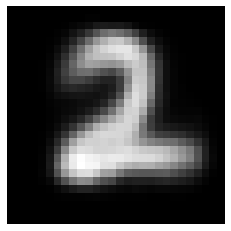

In [ ]:
# Sampling from prior

dec = vae.decoder(nd.array([[0.5,0.5], [1,1]]))
img, _ = np.split(dec, axis=1, indices_or_sections=2)
plt.imshow(img[0].asnumpy().reshape((s,s)), cmap='gray')
plt.axis('off')
plt.show()

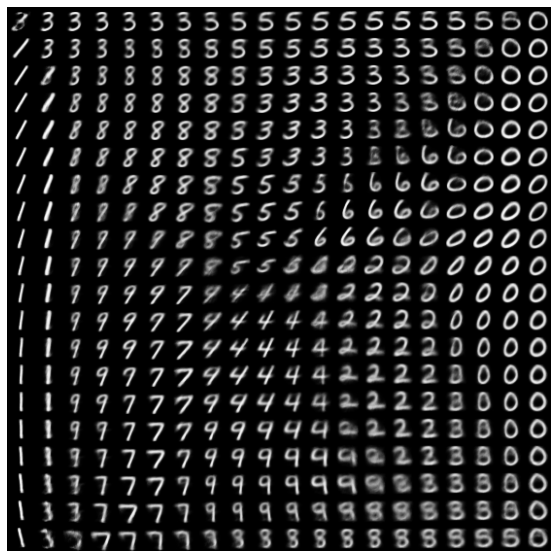

In [ ]:
# random priors in some range
from scipy.stats import norm

s = 28 # size
n_samples = 20
xs = ys = norm.ppf(np.linspace(0.01, 0.99, n_samples))
xx, yy = np.meshgrid(xs, ys)
grid = np.empty((n_samples * s, n_samples * s))
for i, x in enumerate(xx):
    for j, y in enumerate(yy):
        dec = vae.decoder(nd.array([[x[i],y[j]], [x[i], y[j]]]))
        img, _ = np.split(dec, axis=1, indices_or_sections=2)
        grid[i*s:i*s+s, j*s:j*s+s] = img[0].asnumpy().reshape((s,s))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid,cmap='gray')
ax.axis('off')
plt.show()

### Latent space

Below we see the latent space produced by the network. Similary to above in the grid, we see that 0 and 1 are far apart from each other, 7 is close to 1, etc. Also we note that the latent space is quite continuous, which is what we wanted to achieve by using a VAE. 

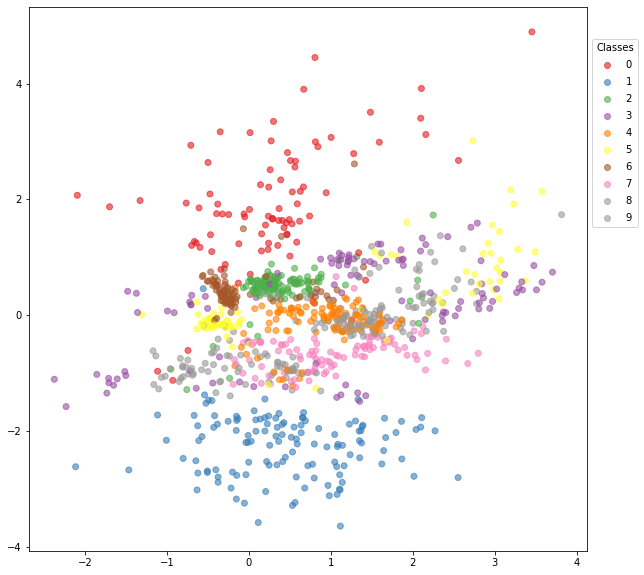

In [ ]:
# Latent representation
n_batches = 10
test_iter.reset()
z_means = []
labels  = []
for _ in range(n_batches):
    test_batch = test_iter.next()
    data = test_batch.data[0].as_in_context(ctx)
    label = test_batch.label[0].asnumpy()
    _, _, z_mean, _ = vae(data)
    z_means.append(z_mean.asnumpy())
    labels.append(label)
z_means = np.vstack(z_means)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(z_means[:,0], z_means[:,1], c=labels, alpha=0.6, cmap='Set1')
handles, lbls = scatter.legend_elements(prop="colors", alpha=0.6)
legend1 = ax.legend(handles, lbls, loc="upper right", title="Classes", bbox_to_anchor=(1.1, 0.95))
plt.show()